In [177]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import s3fs
import tqdm
import subprocess
import shutil, os, glob
import genomeview
import pyBigWig
from plotnine import *

def extract_bw_trace(input_bw, chrom, start, end):
    with pyBigWig.open(input_bw) as bw:
        bw_arr = bw.values(chrom, start, end, numpy=True)
    return bw_arr

def plotdf_bw_series(bw_fn_list, sample_name_list, chrom, start, end):
    results_df = pd.DataFrame()
    for bw_fn,sample_name in zip(bw_fn_list, sample_name_list):
        results_slice = pd.DataFrame({'coverage':extract_bw_trace(bw_fn, chrom, start, end).tolist()})
        results_slice['sample'] = sample_name
        results_slice['pos'] = [x for x in range(start,end)]
        results_df = results_df.append(results_slice)
    return results_df

geneoi_dict = {'g62617.t1':'FBN2',
                'g57506.t1':'BHF',
                'g52047.t1':'RAS10',
                'g50001.t1':'g50001.t1',
                'g71735.t1':'Ahcy',
                'g30477.t1':'VIM',
                'g12356.t1':'FUCA2',
                'g157.t1':'Ahcyl2',
                'g20706.t1':'TKT',
                'g64098.t1':'HrPost-1',
                'g25119.t1':'BAZ2B',
                'g39942.t1':'SMTN',
                'g61047.t1':'g61047.t1',
                'g45293.t1':'SRCAP',
                'g10197.t1':'g10197.t1',
                'g3743.t1':'g3743.t1',
                'g39745.t1':'MASP2',
                'g9431.t1':'Fcn2',
                'g21426.t1':'PARP4',
                'g63396.t1':'Tnn',
                'g32977.t1':'Matn2',
                'g55099.t1':'STT3B',
                'g43887.t1':'LTBP4',
                'g43280.t1':'RASGEF1C',
              }
geneid_list = [x for x,y in geneoi_dict.items()]
genedesc_list = [y for x,y in geneoi_dict.items()]

color_dict = {'Partner 1 soma naive':'#fe0000',
              'Partner 1 test naive':'#feb2b2', 
              'Partner 2 soma naive':'#0000fe', 
              'Partner 2 test naive':'#b2b2fe', 
              'Chimera soma':'#004c00', 
              'Chimera test':'#b2c9b2', 
#               "#D55E00", 
#               "#CC79A7",
             }


In [162]:
crosses_df = (pd.read_csv('s3://darmanis-group/danle/botryllus/botryllus_samples.csv')
              .rename(columns={
                  'Partner 1 soma naaive':'Partner 1 soma naive',
                  'Partner 1 test naïve':'Partner 1 test naive',
                  'Partner 2 soma naaiv':'Partner 2 soma naive',
                  'Partner 2 test naïve':'Partner 2 test naive',
                  'Cimera test':'Chimera test',
                              }
                     )
             )
crosses_df = crosses_df[[x is not np.nan for x in crosses_df['Chimeras set']]] # remove all nan rows
targetfn_df = pd.melt(crosses_df, id_vars=['Chimeras set','Time chimera sampled following fusion'])
targetfn_df['translated_value'] = [ x.replace(' ', '_') \
                                     .replace('  ', '_') \
                                     .replace('.', '_') \
                                     .replace('..', '_') \
                                     .replace('-', '_') \
                                     .replace('--', '_') \
                                     .replace('__', '_') \
                                     .replace('ï','i') if x is not np.nan \
                                   else x \
                                   for x in targetfn_df['value']
                                  ]
# create sample id conversion
value2id_dict = {}
for val_val, key_val in enumerate(targetfn_df['translated_value'].drop_duplicates().dropna()):
    value2id_dict[key_val] = f'sample_{val_val}'
value2id_dict[np.nan] = np.nan
targetfn_df['sample_id'] = [value2id_dict.get(x) for x in targetfn_df['translated_value']]
id2value_dict = {y:x for x,y in value2id_dict.items()} # translate back

# project new sample ids on original experiment matrix
for variable_val in set(targetfn_df['variable']):
    crosses_dict = {}
    targetfn_slice = targetfn_df[targetfn_df['variable']==variable_val]
    targetfn_slice = targetfn_slice[[x is not np.nan for x in targetfn_slice['value']]]
    for row_idx in range(len(targetfn_slice)):
        targetfn_slice_slice = targetfn_slice.iloc[row_idx, :]
        keyval = targetfn_slice_slice['value']
        valval = targetfn_slice_slice['sample_id']
        crosses_dict[keyval] = valval
    crosses_dict[np.nan] = np.nan
    crosses_df[variable_val] = [crosses_dict.get(x) for x in crosses_df[variable_val]]


In [163]:
fs_df = pd.read_csv('/home/daniel_le/data/botryllus/fs.txt', header=None)
fs_df.columns = ['path']
fs_df['fastq'] = [x.endswith('q.gz') for x in fs_df['path']]
fs_df = fs_df[fs_df['fastq'] == True]
fs_df['fn'] = [x.split('/')[-1] for x in fs_df['path']]
fs_df['d1_dir'] = [x.split('/')[-2] for x in fs_df['path']]
fs_df['d1_dir_translated'] = [ x.replace(' ', '_') \
                                 .replace('  ', '_') \
                                 .replace('.', '_') \
                                 .replace('..', '_') \
                                 .replace('-', '_') \
                                 .replace('--', '_') \
                                 .replace('__', '_') \
                               for x in fs_df['d1_dir']
                              ]
fs_df['fn_translated'] = [ x.replace(' ', '_') \
                                 .replace('  ', '_') \
                                 .replace('.', '_') \
                                 .replace('..', '_') \
                                 .replace('-', '_') \
                                 .replace('--', '_') \
                                 .replace('__', '_') \
                               for x in fs_df['fn']
                              ]


In [164]:
match_df = pd.DataFrame()
for target in tqdm.tqdm(targetfn_df['translated_value'].drop_duplicates().dropna()):
    if '944axByd196_6_x_sc109e_92' in target:
        word_len = 30
    else:
        word_len = len(target)
    fs_df_slice = fs_df[[x.startswith(target[:word_len]) or y.startswith(target[:word_len]) \
                         for x,y in zip(fs_df['fn_translated'], fs_df['d1_dir_translated'])]]
    fs_df_slice['target'] = target
    match_df = match_df.append(fs_df_slice)
match_df['sample_id'] = [value2id_dict.get(x) for x in match_df['target']]
match_df = match_df.drop_duplicates()

# metrics
targets = set(targetfn_df['translated_value'].dropna())
print('targets:', len(targets))

hits = set(match_df['target'])
print('hits:', len(hits))

missing = targets-hits
[print(x) for x in missing]


  0%|          | 0/98 [00:00<?, ?it/s]/home/daniel_le/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
100%|██████████| 98/98 [00:00<00:00, 249.21it/s]

targets: 98
hits: 97
3966_944axByd196_6_x_sc109e_92_resorbing_zooid_early_D_chimera_944_side_DCRS


[None]

In [165]:
# check if R1/R2 are properly paired
match_df['fn_translated_prefix'] = [(x
                                     .replace('-R1.','_R2_')
                                     .replace('_R1_','_R2_')
                                    ) for x in match_df['fn_translated']]
match_df_check = pd.DataFrame(match_df
                              .groupby('sample_id')['fn_translated_prefix']
                              .value_counts()
                              .rename('count')).reset_index()
match_df_check[match_df_check['count']!=2]


,sample_id,fn_translated_prefix,count


In [166]:
run_me = False
if run_me == True:
    output_dir = '/home/daniel_le/data/botryllus/results/'
    tmp_dir = '/home/daniel_le/data/botryllus/tmp/'
    indexed_fasta = '/home/daniel_le/data/botryllus/genome/botznik-chr.fa'
    n_threads = 32

    # update queue based on completed targets
    queued_targets = list(set(match_df['sample_id']))
    completed_targets = [x.split('/')[-1].split('.sorted.bam.bai')[0] for x in glob.glob(f'{output_dir}*') if x.endswith('.bai')]
    queued_targets = list(set(queued_targets)-set(completed_targets))

    # iterate through queue
#     for sample in tqdm.tqdm(queued_targets):
    for sample in tqdm.tqdm(['sample_73']): # for single testing
        print('starting', sample)
        # prep tmp folder
        if os.path.exists(tmp_dir):
            shutil.rmtree(tmp_dir)
            os.mkdir(tmp_dir)
        else:
            os.mkdir(tmp_dir)
        # prep output foler    
        if os.path.exists(output_dir):
            pass
        else:
            os.mkdir(output_dir)

    #     # set file names
        tmp_R1_fn = f'{tmp_dir}R1.fq.gz'
        tmp_R2_fn = f'{tmp_dir}R2.fq.gz'
        tmp_sam = f'{tmp_dir}{sample}.sam'
        tmp_bam = f'{tmp_dir}{sample}.bam'
        output_sortedbam = f'{output_dir}{sample}.sorted.bam'

        # rclone subprocess call to download files
        match_df_slice = match_df[match_df['sample_id'] == sample]
        input_fastqs = match_df_slice['path'].tolist()
        for input_path in input_fastqs:
            subprocess.call(['rclone',
                             'copy',
                             f'gdrive:Botryllus/{input_path}',
                             tmp_dir,
                            ])

        # extract files in tmp for cat
        R1_inputs = sorted([x for x in glob.glob(f'{tmp_dir}*') if ('-R1.' in x) or ('_R1_' in x)])
        R2_inputs = sorted([x for x in glob.glob(f'{tmp_dir}*') if ('-R2.' in x) or ('_R2_' in x)])
        for inputs,outfn in zip([R1_inputs,R2_inputs], [tmp_R1_fn,tmp_R2_fn]):
            for input_fn in inputs:
                with open(outfn, 'a') as outfile:
                    subprocess.call(['cat', input_fn], stdout=outfile)

        # run bwa mem
        with open(tmp_sam, 'w') as outfile:
            subprocess.call(['bwa',
                             'mem',
                             '-t',
                             str(n_threads),
                             '-M',
                             indexed_fasta,
                             tmp_R1_fn,
                             tmp_R2_fn,
                            ], stdout=outfile)

        # samtools convert sam to bam
        with open(tmp_bam, 'w') as outfile:
            subprocess.call(['samtools',
                             'view',
                             '-S',
                             '-b',
                             tmp_sam,
                            ], stdout=outfile)

        # samtools sort bam
        with open(output_sortedbam, 'w') as outfile:
            subprocess.call(['samtools',
                             'sort',
                             tmp_bam,
                            ], stdout=outfile)

        # samtools index sorted bam
        subprocess.call(['samtools',
                         'index',
                         output_sortedbam,
                        ])

        print('completed')


---
Chimeras set: Set 7 chimera during resorption 944axByd196.6 x sc109e.92
Sampling time: 1 month following fusion during resorption
---
Partner 1 soma naive : A1M1B_Sample_sc109e_bud_stage_a_IL2381_10
Partner 2 soma naive : HISeq_Sample_944axbyd196_1
Chimera soma : 3948_944axByd196_6_x_sc109e_92_Blood_microinjector_sample_early_D_chimera_DCRS


/home/daniel_le/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


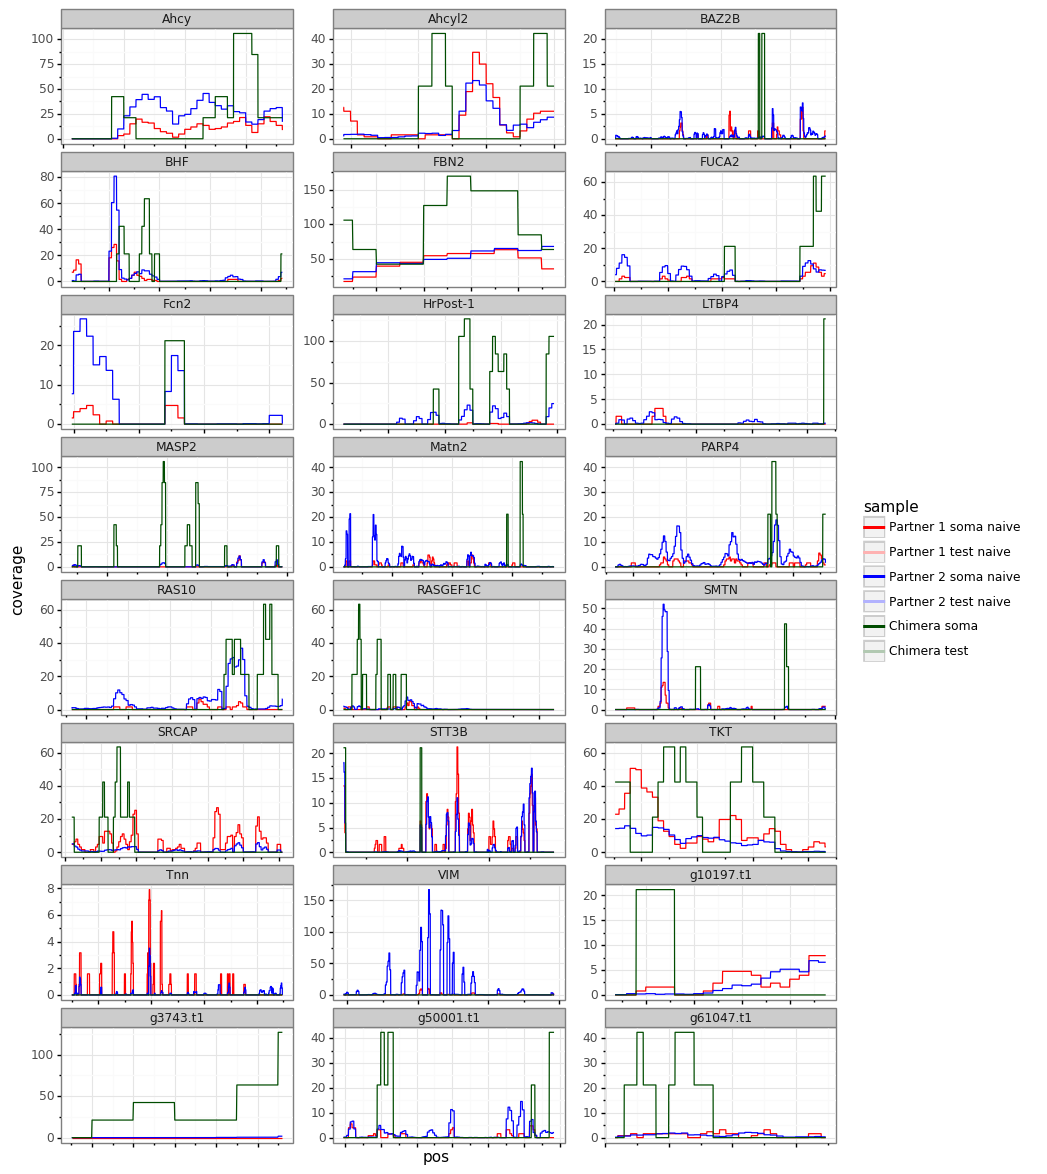

<ggplot: (8783362729121)>


/home/daniel_le/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


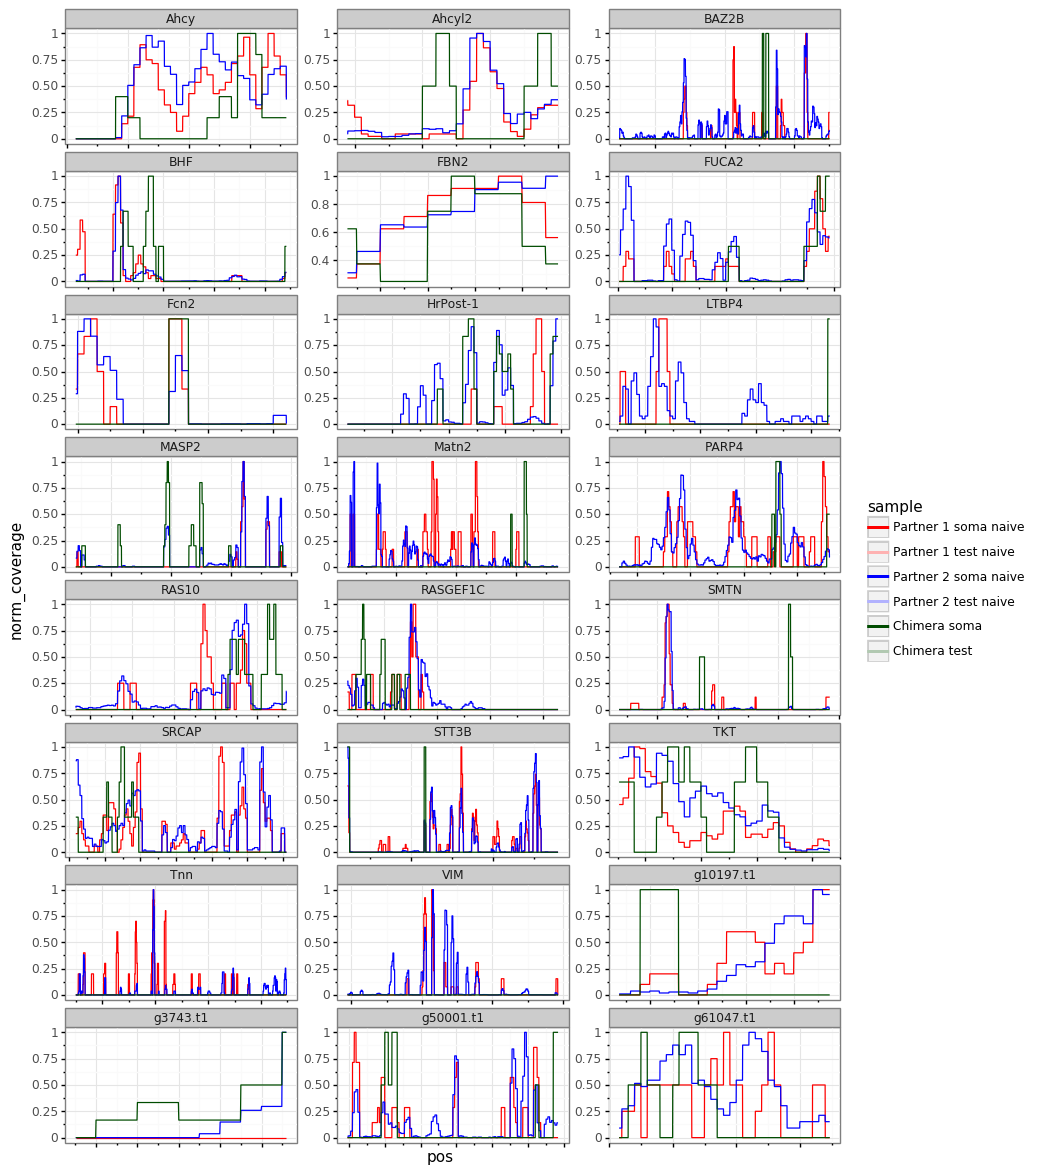

<ggplot: (8783369558405)>


In [222]:
# extract samples from a Chimera set for pile up display
row_idx = 21

cross_slice = crosses_df.iloc[row_idx,:].T.tolist()
cross_slice_dict = crosses_df.iloc[row_idx,:].to_dict()
print('---')
print('Chimeras set:', cross_slice_dict.get('Chimeras set'))
print('Sampling time:', cross_slice_dict.get('Time chimera sampled following fusion'))
print('---')
cross_slice_dict = {y:x for x,y in cross_slice_dict.items()}
sample_list = [x.split('_')[-1] for x in cross_slice if str(x).startswith('sample_')]

fasta_path = '/home/daniel_le/data/botryllus/genome/botznik-chr.fa'
n_threads = 16

# check and process as needed
for sample_index in sample_list:
    try:
        bw_path = f'/home/daniel_le/data/botryllus/coverage/sample_{sample_index}.bw'
        bam_path = f'/home/daniel_le/data/botryllus/results/sample_{sample_index}.sorted.bam'
        print(cross_slice_dict.get(f'sample_{sample_index}'), 
              ':',
              id2value_dict.get(f'sample_{sample_index}')
             )
        if not os.path.exists(bw_path):
            subprocess.call([
                            'bamCoverage',
                            '-p',
                            str(n_threads),
                            '--normalizeUsing',
                            'CPM',
                            '--ignoreDuplicates',
                            '-b',
                            bam_path,
                            '-o',
                            bw_path,
                            ])
    except:
        pass

# plot set
bw_fn_list = [f'/home/daniel_le/data/botryllus/coverage/sample_{sample_index}.bw' for sample_index in sample_list]
sample_name_list = [cross_slice_dict.get(f'sample_{sample_index}') for sample_index in sample_list]

# ingest gene positions in bed file
genebed_path = '/home/daniel_le/data/botryllus/genome/botznik-chr-all.bed'
bed_df = pd.read_csv(genebed_path, sep = '\t', header = None)
bed_df.columns = ['chrom','start','end','name','ph1','ph2','ph3','ph4','ph5','ph6','ph7','ph8']

# process all genes of interest and append desc.
master_plotdf = pd.DataFrame()
for gene_id in geneid_list: 
    chrom = bed_df.query(f'name == "{gene_id}"').chrom.tolist()[0]
    start = bed_df.query(f'name == "{gene_id}"').start.tolist()[0]
    end =   bed_df.query(f'name == "{gene_id}"').end.tolist()[0]

    plotdf = plotdf_bw_series(bw_fn_list, sample_name_list, chrom, start, end)
    plotdf['gene_id'] = gene_id
    plotdf['gene_desc'] = geneoi_dict.get(gene_id)
    plotdf = plotdf.rename(columns={'coverage':'value'})
    plotdf['variable'] = 'coverage'    
    
    plotdf_norm = (pd.DataFrame(plotdf.groupby(['variable','gene_id','gene_desc','sample','pos'])['value'].sum()/ \
                               plotdf.groupby(['variable','gene_id','gene_desc','sample'])['value'].max()
                                 )
                    .replace(np.nan, 0)
                    .reset_index()
                  )
    plotdf_norm['variable'] = 'norm_coverage'
    plotdf = plotdf.append(plotdf_norm)
    master_plotdf = master_plotdf.append(plotdf)

for grid_val in ['coverage', 'norm_coverage']:
    plotdf_filter = master_plotdf.query(f'variable == "{grid_val}"')
    plotdf_filter['sample'] = (plotdf_filter['sample']
                    .astype(str)
                    .astype(CategoricalDtype([x for x in color_dict.keys()], ordered=True))
                   )
    plotnine.options.figure_size = (10,10)
    plot = (ggplot(plotdf_filter)
            + theme_bw()
            + theme(aspect_ratio = 1/2,
                    axis_text_x = element_blank(),
                    panel_spacing_x = 0.4,
                   )
            + geom_line(aes('pos','value',color='sample',group='sample'))
            + facet_wrap('~gene_desc', scales='free', ncol=3)
            + labs(y=grid_val, x = 'pos')
            + scale_color_manual(values=color_dict)
           )
    print(plot)

    

In [151]:
crosses_df

,Chimeras set,Partner 1 soma naive,Partner 1 test naive,Partner 2 soma naive,Partner 2 test naive,Chimera soma,Cimera test,Time chimera sampled following fusion
0,Control 1 touch- 5139jL11HMBYSc6ab15 vs 944axB...,sample_0,NaN,sample_31,NaN,sample_47,NaN,touching no blood vessel fused
1,Control 1 touch- 5139jL11HMBYSc6ab15 vs 944axB...,sample_1,NaN,sample_32,NaN,sample_48,NaN,touching no blood vessel fused
2,Control 1 touch- 5139jL11HMBYSc6ab15 vs 944axB...,sample_2,NaN,sample_33,NaN,sample_49,NaN,touching no blood vessel fused
3,Control 1 touch- 5139jL11HMBYSc6ab15 vs 944axB...,sample_3,NaN,sample_34,NaN,sample_50,NaN,touching no blood vessel fused
4,Control 1 touch- 5139jL11HMBYSc6ab15 vs 944axB...,sample_4,NaN,sample_35,NaN,sample_51,NaN,touching no blood vessel fused
5,Control 1 touch- 5139jL11HMBYSc6ab15 vs 944axB...,NaN,NaN,sample_36,NaN,sample_52,NaN,touching no blood vessel fused
6,Set 1 chimera- 5139jL11HMBYSc6ab15 vs 944axBYd...,sample_3,NaN,sample_33,NaN,sample_53,sample_87,2 months
7,Set 1 chimera- 5139jL11HMBYSc6ab15 vs 944axBYd...,sample_4,NaN,sample_34,NaN,sample_54,sample_88,2 months
8,Set 2_ chimera 944axBYd196.6.4 vs. HM9axBYd196...,sample_5,NaN,sample_37,NaN,sample_55,sample_89,5 months
9,Set 2_ chimera 944axBYd196.6.4 vs. HM9axBYd196...,NaN,NaN,sample_38,NaN,sample_56,NaN,5 months
